In [ ]:
%pip install SpeechRecognition
%pip install gtts
%pip install pyaudio
%pip install pandas
%pip install re
%pip install tensorflow
%pip install numpy
%pip install keras
%pip install tensorflow-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyaudio
Failed to build pyaudio
ERROR: Could not build wheels for pyaudio, which is required to install pyproject.toml-based projects
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
ERROR: Could not find a version that satisfies the requirement tensorflow-keras (from versions: none)
ERROR: No matching distribution found for tensorfl

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import speech_recognition as sr
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split
import json

In [ ]:
# Metin verisini sayısal verilere dönüştürmek için tokenizer yükleme
tokenizer = Tokenizer(num_words=25000)
data = pd.read_csv("_data.csv", header=0, delimiter="\t", quoting=3)
data['Review'] = data['Review'].astype(str).apply(lambda x: x.lower())
turkish_chars = "a|b|c|ç|d|e|f|g|ğ|h|ı|i|j|k|l|m|n|o|ö|p|r|s|ş|t|u|ü|v|y|z|0-9"
data['Review'] = data['Review'].apply(lambda x: re.sub('[^'+turkish_chars+'\s]','',x))
tokenizer.fit_on_texts(data['Review'].values)

# Önceden eğitilmiş modeli yükleme
from tensorflow.keras.models import load_model
model = load_model('sentiment_analysis_model.h5')

In [ ]:
# Nabız aralığına göre duygusal durum tablosu
emotion_table = {
    (50, 60): "Dinlenme/Rahatlama",
    (60, 80): "Huzur/Mutluluk/Üzüntü",
    (80, 90): "Normal/Nötr",
    (90, 100): "Hafif Stres/Kaygı/Heyecan",
    (100, 110): "Yüksek Stres/Korku/Panik",
    (110, 220): "Aşırı Heyecan/Şiddetli Korku"
}

def get_emotion_from_heart_rate(heart_rate):
    for range_tuple, emotion in emotion_table.items():
        if range_tuple[0] <= heart_rate < range_tuple[1]:
            return emotion
    return None

In [ ]:
# Ses kaydından metin çevirme ve duygu analizi
def perform_sentiment_analysis(audio_file_path, heart_rate):
    r = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio_data = r.listen(source)
        try:
            text = r.recognize_google(audio_data, language="tr-TR")
            print("Ses Metni:")
            print(text)
            sequences = tokenizer.texts_to_sequences([text])
            data = pad_sequences(sequences, maxlen=400)
            prediction = model.predict(data)
            positive_prob = prediction[0][1] * 100
            negative_prob = prediction[0][0] * 100
            print("Duygu Analizi Sonucu:")
            print("-------------------------")
            print(f"\033[92mOlumlu Olasılık: %{positive_prob:.2f}\033[0m")
            print(f"\033[91mOlumsuz Olasılık: %{negative_prob:.2f}\033[0m")
            print("-------------------------")

            emotion = get_emotion_from_heart_rate(heart_rate)
            if emotion is None:
                print("Hatalı Nabız Değeri. Lütfen Doğru Değeri Girin!")
                return None

            if 45 <= positive_prob <= 55:
                sentiment = "Nötr"
                color = "\033[93m"  # Yellow
            elif positive_prob > negative_prob:
                sentiment = "Olumlu"
                color = "\033[92m"  # Green
            else:
                sentiment = "Olumsuz"
                color = "\033[91m"  # Red

            result = f"Kişi {emotion} Durumunda ve Cümlesi {sentiment}."
            print(f"\033[1m{color}{result}\033[0m")  # Bold and colored text
            return prediction
        except sr.UnknownValueError:
            print("Ses anlaşılamadı.")
            return None
        except sr.RequestError as e:
            print("Hata:", e)
            return None

Lütfen Ses Kaydını Uzantısı ile Giriniz: res.wav
Kişinin ortalama nabzını giriniz (BPM): 85
Ses Metni:
bu Restoran ne çok iyi ne de çok kötüydü yemekler orta karar ama fiyatlar biraz yüksekti hizmette Ne iyi ne kötüydü
1/1 [==============================] - 0s 156ms/step
Duygu Analizi Sonucu:
-------------------------
Olumlu Olasılık: %48.23
Olumsuz Olasılık: %51.77
-------------------------
Kişi Normal/Nötr Durumunda ve Cümlesi Nötr.


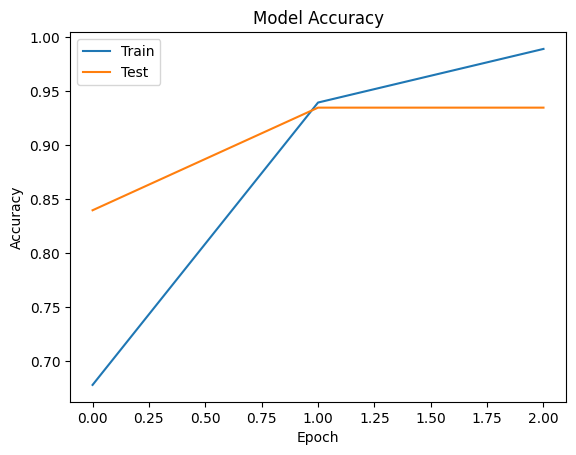

In [ ]:
# Duygu analizini gerçekleştirmek için bir örnek
audio_file_path = str(input("Lütfen Ses Kaydını Uzantısı ile Giriniz: "))
while True:
    try:
        heart_rate = float(input("Kişinin ortalama nabzını giriniz (BPM): "))  # Nabız verisini manuel olarak giriniz
        if get_emotion_from_heart_rate(heart_rate) is not None:
            break
        else:
            print("Hatalı Nabız Değeri. Lütfen Doğru Değeri Girin!")
    except ValueError:
        print("Geçersiz giriş. Lütfen sayısal bir değer girin.")

perform_sentiment_analysis(audio_file_path, heart_rate)

# Eğitim sürecinin görselleştirilmesi için history.json dosyasını yükleme
with open('history.json', 'r') as f:
    history = json.load(f)

# Visualize the training process
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()